<a href="https://colab.research.google.com/github/mvfolino68/PyconUS_2019-model-interpretability-tutorial/blob/master/Machine_Learning_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning Modeling and Interpretability

##Problem Definition

Build a classifiers that given characteristics about an individual, and how they were approached by the marketing team, we can predict whether they will subscribe to a term deposit (column `y`).

##Set up environment

In [0]:
# Setup Colab
!wget https://raw.githubusercontent.com/mvfolino68/PyconUS_2019-model-interpretability-tutorial/master/setup_colab.sh
!bash setup_colab.sh

In [0]:
# data maninpulation
import pandas as pd
import numpy as np


# Some sklearn tools for preprocessing. 
# ColumnTransformer was introduced in 0.20 so make sure you have this version
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV

# In terms of metric we'll need balanced accuracy score and classification report
# More on that later...
from sklearn.metrics import balanced_accuracy_score, classification_report, confusion_matrix

# Our algorithms, from the easiest to the hardest to intepret.
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm.sklearn import LGBMClassifier

# import our visualization libs
import seaborn as sns
import matplotlib.pyplot as plt
#import matplotlib.pylab as pylab
import matplotlib as mpl
#visualization settings
sns.set(style='white', context='notebook', palette='deep')
# pylab.rcParams['figure.figsize'] = 12,8
mpl.style.use('ggplot')
sns.set_style('white')
%matplotlib inline

## Get the Data

The data is based on a dataset available [here](https://archive.ics.uci.edu/ml/datasets/bank+marketing). 

It consists of data from marketing campaigns of a Portuguese bank. We will build classifiers that given characteristics about an individual, and how they were approached by the marketing team, we can predict whether they will subscribe to a term deposit (column `y`). 


1. `age` (numeric)
2. `job` : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3. `marital` : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4. `education` (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5. `default`: has credit in default? (categorical: 'no','yes','unknown')
6. `housing`: has housing loan? (categorical: 'no','yes','unknown')
7. `loan`: has personal loan? (categorical: 'no','yes','unknown')
8. `contact`: contact communication type (categorical: 'cellular','telephone') 
9. `month`: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10. `day_of_week`: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11. `campaign`: number of contacts performed during this campaign and for this client (numeric, includes last contact)
12. `pdays`: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
13. `previous`: number of contacts performed before this campaign and for this client (numeric)
14. `poutcome`: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

In [10]:
df = pd.read_csv("data/bank.csv")
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,no


In [11]:
#let's look at the dataframe's data types
df.dtypes

age             int64
job            object
marital        object
education      object
default        object
housing        object
loan           object
contact        object
month          object
day_of_week    object
campaign        int64
pdays           int64
previous        int64
poutcome       object
y              object
dtype: object

In [12]:
#summary stats of numerical data
df.describe()

,age,campaign,pdays,previous
count,41188.00000,41188.000000,41188.000000,41188.000000
mean,40.02406,2.567593,962.475454,0.172963
std,10.42125,2.770014,186.910907,0.494901
min,17.00000,1.000000,0.000000,0.000000
25%,32.00000,1.000000,999.000000,0.000000
50%,38.00000,2.000000,999.000000,0.000000
75%,47.00000,3.000000,999.000000,0.000000
max,98.00000,56.000000,999.000000,7.000000


In [13]:
#desribe categorical features
df.describe(include=['O'])

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,y
count,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188
unique,12,4,8,3,3,3,2,10,5,3,2
top,admin.,married,university.degree,no,yes,no,cellular,may,thu,nonexistent,no
freq,10422,24928,12168,32588,21576,33950,26144,13769,8623,35563,36548


##Explore the Data

In [0]:
# Get the feature matrix (X) and the target vector (y) and convert the y variable to 0 and 0 for comparison 
y = df["y"].map({"no": 0, "yes": 1})
X = df.drop("y", axis=1)
#convert original DF y variable for analysis
df['y'] = df["y"].map({"no": 0, "yes": 1})

####The dataset is imbalanced, we will need to keep that in mind when building our models...

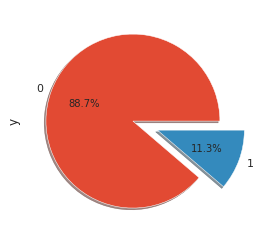

In [15]:
df.y.value_counts()
df.y.value_counts().plot.pie(explode=[0,0.3],autopct='%1.1f%%',shadow=True)
plt.show()

####Categorical Variable Analysis

Students seem to have the highest percentage of success

In [22]:
df[["job", "y"]].groupby(['job'], as_index=False).agg({"y": [np.mean, np.sum]}).sort_values(by = ('y', 'mean'), ascending=False)

job         y      
                       mean   sum
8         student  0.314286   275
5         retired  0.252326   434
10     unemployed  0.142012   144
0          admin.  0.129726  1352
4      management  0.112175   328
11        unknown  0.112121    37
9      technician  0.108260   730
6   self-employed  0.104856   149
3       housemaid  0.100000   106
2    entrepreneur  0.085165   124
7        services  0.081381   323
1     blue-collar  0.068943   638

Single people are more likely to sign up

In [21]:
df[["marital", "y"]].groupby(['marital'], as_index=False).agg({"y": [np.mean, np.sum]}).sort_values(by = ('y', 'mean'), ascending=False)

marital         y      
                 mean   sum
3   unknown  0.150000    12
2    single  0.140041  1620
0  divorced  0.103209   476
1   married  0.101573  2532

Hmm it seems like this strategy works well on 

In [23]:
df[["education", "y"]].groupby(['education'], as_index=False).agg({"y": [np.mean, np.sum]}).sort_values(by = ('y', 'mean'), ascending=False)

education         y      
                            mean   sum
4           illiterate  0.222222     4
7              unknown  0.145003   251
6    university.degree  0.137245  1670
5  professional.course  0.113485   595
3          high.school  0.108355  1031
0             basic.4y  0.102490   428
1             basic.6y  0.082024   188
2             basic.9y  0.078246   473

Contacts by cellular are signigicatly more effective

In [24]:
df[["contact", "y"]].groupby(['contact'], as_index=False).agg({"y": [np.mean, np.sum]}).sort_values(by = ('y', 'mean'), ascending=False)

contact         y      
                  mean   sum
0   cellular  0.147376  3853
1  telephone  0.052313   787

####Visuals

The number of contacts seems to have a significant impact of whether a customer signs up or not

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


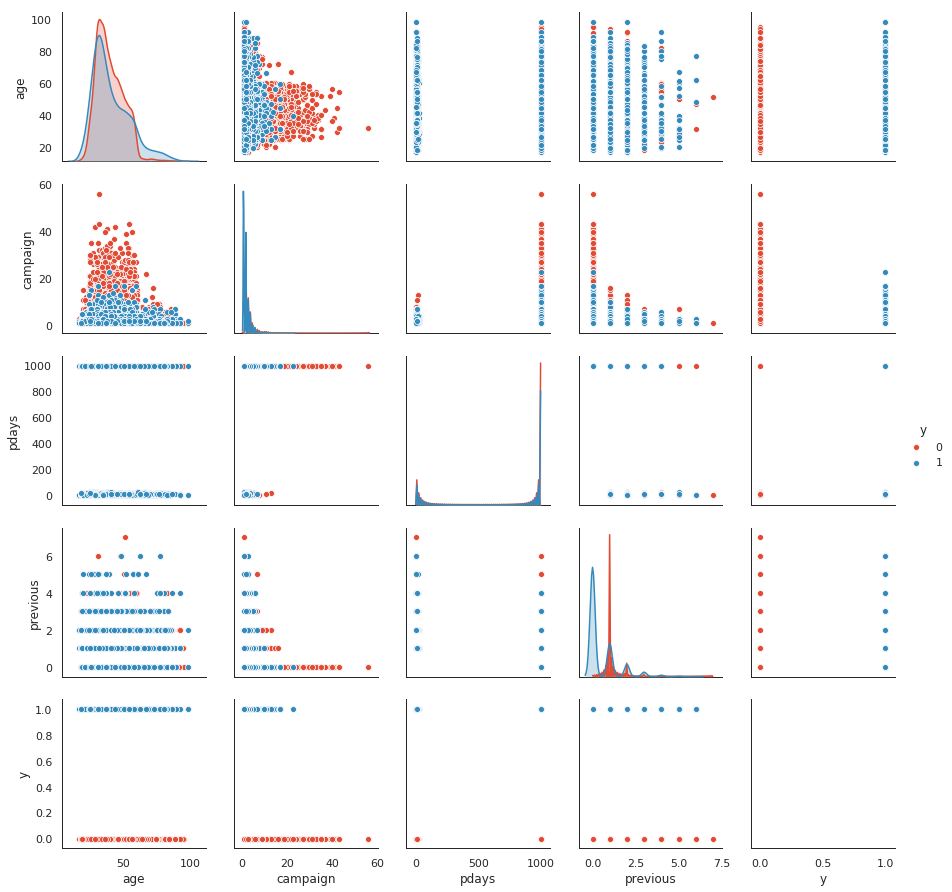

In [25]:
# Using seaborn pairplot to see the bivariate relation between each pair of numerical features
sns.pairplot(df, hue="y");

A histogram chart is useful for analyzing continous numerical variables like Age where banding or ranges will help identify useful patterns. The histogram can indicate distribution of samples using automatically defined bins or equally ranged bands. This helps us answer questions relating to specific bands

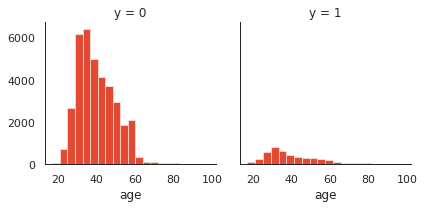

In [26]:
#histogram of age
g = sns.FacetGrid(df, col='y')
g.map(plt.hist, 'age', bins=20)

##Let's begin to preprocess data, one hot encoding categorical features

What features do you expect to be relevant to predict whether someone will subscribe to our plan?

To find those, we will train models and interpret them.

First, let's create a list of numerical and categorical features so we can easily select one or the other later:

In [0]:
# Some such as default would be binary features, but since
# they have a third class "unknown" we'll process them as non binary categorical
num_features = ["age", "campaign", "pdays", "previous"]

cat_features = ["job", "marital", "education","default", "housing", "loan",
                "contact", "month", "day_of_week", "poutcome"]

First, we'll define a new `ColumnTransformer` object that just keeps our numerical features as they are and apply one hot encoding on our categorical features. This transformer can be fitted on the training set and used to transform the test set in the same way:

In [0]:
preprocessor = ColumnTransformer([("numerical", "passthrough", num_features), 
                                  ("categorical", OneHotEncoder(sparse=False, handle_unknown="ignore"),
                                   cat_features)])

Let's split the data into training and test sets. Create `X_train`, `X_test`, `y_train` and `y_test` using `train_test_split` from sklearn: Make sure to set stratify to y because the outcome variable is unbalanced

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.3, random_state=42)


Now we can create processed versions of X_train and X_test, ready to be used by our algorithms. To do so we will start by fitting the processor on X_train:

In [30]:
preprocessor.fit(X_train)

preprocessor.transform(X_train)

array([[ 50.,   2., 999., ...,   0.,   1.,   0.],
       [ 51.,   5., 999., ...,   0.,   1.,   0.],
       [ 46.,   2., 999., ...,   0.,   1.,   0.],
       ...,
       [ 35.,   3., 999., ...,   0.,   1.,   0.],
       [ 32.,   4., 999., ...,   0.,   1.,   0.],
       [ 31.,   3., 999., ...,   0.,   1.,   0.]])

When we call transform, the preprocessor returns a numpy array, which is great for Machine Learning algorithms to process ... but not so great for us humans to interpret. So we will wrap it up back to DataFrame with nice column names. To do so we will need to give nice names to the dummy feature generated by the one hot encoder. The code below extracts the list of categories, creates nice names for the dummy feature and create a new list `all_features` with good names for our columns:

In [0]:
# Get the list of categories generated by the process
ohe_categories = preprocessor.named_transformers_["categorical"].categories_

# Create nice names for our one hot encoded features
new_ohe_features = [f"{col}__{val}" for col, vals in zip(cat_features, ohe_categories) for val in vals]

# Create a new list with all names of features
all_features = num_features + new_ohe_features

Great, now we can create our preprocessed DataFrames with good column names:

In [0]:
X_train = pd.DataFrame(preprocessor.transform(X_train), columns=all_features)
X_test = pd.DataFrame(preprocessor.transform(X_test), columns=all_features)

In [33]:
X_train.head()

,age,campaign,pdays,previous,job__admin.,job__blue-collar,job__entrepreneur,job__housemaid,job__management,job__retired,...,month__oct,month__sep,day_of_week__fri,day_of_week__mon,day_of_week__thu,day_of_week__tue,day_of_week__wed,poutcome__failure,poutcome__nonexistent,poutcome__success
0,50.0,2.0,999.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,51.0,5.0,999.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,46.0,2.0,999.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,46.0,1.0,999.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,25.0,5.0,999.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


Looks good!

##Select Model(s)

Let's start with a LogisticRegression:

In [0]:
# Logistic Regression
lr_model = LogisticRegression(class_weight="balanced", solver="liblinear", random_state=42)

Here we keep most parameters to default as we'll tune the model later. But defined `class_weight` to be balanced in order to take into account the imbalance in our dataset.

In [0]:
# Decision Tree
dt_model = DecisionTreeClassifier(class_weight="balanced")

# Random Forest
rf_model = RandomForestClassifier(class_weight="balanced", n_estimators=150, n_jobs=-1)

# LightGBM -- Boosting model
lgb_model = LGBMClassifier(class_weight="balanced", n_jobs=-1)


##Train models with cross validation and evaluate their performance

### With Logistic Regression

First let's fine tune our logistic regression and evaluate its performance. Here we'll use ["balanced_accuracy"](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html#sklearn.metrics.balanced_accuracy_score) as metric to optimise so it takes into account the imbalance of classes.

In [0]:
gs = GridSearchCV(lr_model, {"C": [1., 1.3, 1.5]}, n_jobs=-1, cv=5, scoring="balanced_accuracy")
gs.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [1.0, 1.3, 1.5]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='balanced_accuracy',
       verbose=0)

Let's see our best parameters and score

Check the best parameters and best score from the GridSearch object:

In [0]:
print(gs.best_params_)
print(gs.best_score_)


{'C': 1.5}
0.6973078694024336


Since `GridSearchCV` has a parameter `refit` that is `True` by default, it has re-fitted the model with best parameters on the whole training set. We can access it using `best_estimator_`

In [0]:
# LR model is our best trained model for LR
lr_model = gs.best_estimator_

Let's check that our model has properly been updated:

In [0]:
lr_model.get_params()

{'C': 1.5,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'max_iter': 100,
 'multi_class': 'warn',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

####Test and Evaluate Model Performance

In [0]:
# Generate Predictions classification report and confusion matrix
y_pred = lr_model.predict(X_test)
lracc = balanced_accuracy_score(y_test, y_pred)
print('Model Accuracy')
print(lracc)
print('--------------------------------------------------------------')
print('Classification Report')
print(classification_report(y_test, y_pred))
print('--------------------------------------------------------------')
print('Confusion Matrix')
df_confusion = pd.crosstab(y_test, y_pred)
df_confusion = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)
df_confusion

Model Accuracy
0.7040817570011164
--------------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

           0       0.94      0.82      0.88     10965
           1       0.29      0.59      0.39      1392

   micro avg       0.79      0.79      0.79     12357
   macro avg       0.62      0.70      0.63     12357
weighted avg       0.87      0.79      0.82     12357

--------------------------------------------------------------
Confusion Matrix


Predicted,0,1,All
Actual,,,
0,8997,1968,10965
1,574,818,1392
All,9571,2786,12357


####Model Interpretability
Great, so now we have a simple model that can predict if someone will subscribe to our plan. This isn't a great model in terms of accuracy, but it's simple enough that we can easily look inside the box and understand how it works.

For that we'll use `eli5` that will allow us to visualise the weights associated to each feature.

Import eli5 and use `show_weights` to visualise the weights of your model, don't forget to pass your column names as well so `eli5` can display them instead of the column number (check the documentation for `show_weights`)

In [0]:
import eli5

eli5.show_weights(lr_model, feature_names=all_features)


Weight?,Feature
+1.170,month__mar
+1.117,month__dec
+0.968,education__illiterate
+0.920,month__oct
+0.711,contact__cellular
+0.619,month__sep
+0.615,job__retired
+0.580,job__student
+0.564,default__no
+0.528,<BIAS>


That's easier to read. This table gives us the weight associated to each feature. The amplitude tells us how much of an impact a feature has on the predictions on average, the sign tells us in which direction. Here if the campaign is in March, it increases the probability of the prospect to subscribe to the plan significantly. Has the marketting team done something different in March? Or are prospects just more likely to subscribe in March? That's a question to ask to the marketting team, depending on the answer, this finding might or might not be useful.

We can also use `eli5` to explain a specific prediction, let's pick a row in the test data:

In [0]:
i = 4
X_test.iloc[[i]]

,age,campaign,pdays,previous,job__admin.,job__blue-collar,job__entrepreneur,job__housemaid,job__management,job__retired,...,month__oct,month__sep,day_of_week__fri,day_of_week__mon,day_of_week__thu,day_of_week__tue,day_of_week__wed,poutcome__failure,poutcome__nonexistent,poutcome__success
4,27.0,4.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [0]:
y_test.iloc[i]

1

Our prospect subsribed to the term deposit after the campaign! Let's see what our model would have predicted and how we could explain it to the domain expert.

In [0]:
eli5.show_prediction(lr_model, X_test.iloc[i],
                     feature_names=all_features, show_feature_values=True)

Here `eli5` does something really simple: knowing the weights associated to each feature and the actual value for all features for this specific observation, it can compute the contribution of each feature towards the prediction. 

For this prediction, it looks like the most important factor was that the prospect was contacted via phone (`contact__cellular`==1) and did not have a default (`default__no`==1). That's interesting information that you could share with the team member who was in touch with this prospect, to trigger a discussion on why those features were important.

### with a Decision Tree

`eli5` can also be used to intepret decision trees:

Use grid search to find the best parameters for your Decision Tree:

In [0]:
gs = GridSearchCV(dt_model, {"max_depth": [8, 10, 15], 
                             "min_samples_split": [.005, .01, .05]}, 
                  n_jobs=-1, cv=5, scoring="balanced_accuracy")

gs.fit(X_train, y_train)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [8, 10, 15], 'min_samples_split': [0.005, 0.01, 0.05]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='balanced_accuracy', verbose=0)

Let's see our best parameters and score:

In [0]:
print(gs.best_params_)
print(gs.best_score_)


{'max_depth': 10, 'min_samples_split': 0.01}
0.6975556335157104


Store the best model `best_estimator_` into a new variable `dt_model` that we can try to interpret later:

In [0]:
dt_model = gs.best_estimator_


####Test and Evaluate Model Performance!

In [0]:
# Generate Predictions classification report and confusion matrix
y_pred = dt_model.predict(X_test)
dtacc = balanced_accuracy_score(y_test, y_pred)
print('Model Accuracy')
print(dtacc)
print('--------------------------------------------------------------')
print('Classification Report')
print(classification_report(y_test, y_pred))
print('--------------------------------------------------------------')
print('Confusion Matrix')
df_confusion = pd.crosstab(y_test, y_pred)
df_confusion = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)
df_confusion


Model Accuracy
0.7103689049797947
--------------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

           0       0.94      0.83      0.88     10965
           1       0.31      0.59      0.40      1392

   micro avg       0.80      0.80      0.80     12357
   macro avg       0.62      0.71      0.64     12357
weighted avg       0.87      0.80      0.83     12357

--------------------------------------------------------------
Confusion Matrix


Predicted,0,1,All
Actual,,,
0,9127,1838,10965
1,573,819,1392
All,9700,2657,12357


####Model Interpretability
Unfortunately, for Decision Trees, `eli5` only gives the simple feature importance. It tells you how important different features are on average relative to each other but not how they impact the outcome.

Use `show_weights` on your dt_model:

In [0]:
eli5.show_weights(dt_model, feature_names=all_features)


Weight,Feature
0.3951,pdays
0.1622,contact__telephone
0.0916,age
0.0699,month__oct
0.0584,month__jun
0.0511,month__mar
0.0478,month__apr
0.0331,month__sep
0.0156,month__dec
0.0127,default__unknown


For this model, the most important feature seems to be `pdays` but we don't know if the more days the more likely it is that someone will subscribe, or the opposite. It can be useful to debug your model and know if it seems to pick up something that it shouldn't, but appart for that, it isn't too useful: you won't be able to properly explain what your model does to someone thanks to that.

#### Limitations of the method...

So, `eli5`'s `show_weights` method is good, but for more complex models, such as trees the information provided starts to be less helpful. Since `show_weights` is accessing the internal weights of a model, it does not work with all algorithms, making it harder to compare different models you might have built.

`eli5` implements another technique called Permutation Importance that is model agnostic and works for any black box model. By shuffling at random the values of a feature, we can observe how that affects the predictions and quantify how important that feature is. If we repeat on all features, we can get the overall importance of each feature and compare them. Let's try to do that on our models.

#### Using Permutation Importance for global and model agnostic feature importance

In [0]:
from eli5.sklearn import PermutationImportance

First will need to create a new instance of `PermutationImportance` that takes our trained model to be interpreted and the scoring method (`"balanced_accuracy"`) we which to use to quantify the importance of our features.

Create a PermutationImportance object to interpret your Decision Tree model, and call it `perm`

In [0]:
perm = PermutationImportance(dt_model, scoring="balanced_accuracy")


For the next step, we will need to `fit` our Permutation Importance. We could do so using the training set, but that would just tell us how important each feature was when trying to minimise the accuracy, not how your model will work on new data. 

To ensure your interpretation corresponds to how your model works when it is used on new data, you need to train the permutation importance on unseen data, using the test set for instance.

Call `fit` on your Permutation Importance object, then use `eli5`'s `show_weigths` as before, but passing the `perm` object instead of the model itself. This will plot your new feature importance:

In [0]:
perm.fit(X_test, y_test)
eli5.show_weights(perm, feature_names=all_features)


Weight,Feature
0.0476 ± 0.0062,contact__telephone
0.0372 ± 0.0033,pdays
0.0357 ± 0.0116,month__jun
0.0276 ± 0.0042,month__apr
0.0231 ± 0.0065,age
0.0210 ± 0.0028,month__may
0.0115 ± 0.0027,month__mar
0.0105 ± 0.0018,month__oct
0.0085 ± 0.0011,month__sep
0.0072 ± 0.0032,campaign


Again, here the feature importance is only given as an amplitude, we do not know in what direction it impacts the outcome. But the interpretation is quite interesting; when you will use your model on new data, to predict whether someone will subscribe or not to your plan, the most important thing it will need to get the prediction right is whether you contacted the person by telephone. You're not looking at what the model gave the most importance too whilst learning, but how it will give importance to features from now on based on what it has learnt. It also tells you that variables like whether the person got divorced will be pretty much irrelevant when your model is used.

Since Permutation Importance is model agnostic, we can use it on any other model that we have built, and compare the feature importance. Let's do that with a Random Forest and LightGBM model.

### with a Random Forest

Use grid search to find the best parameters for your `rf_model`

In [0]:
gs = GridSearchCV(rf_model, {"max_depth": [10, 15, 20],
                             "min_samples_split": [.005, .01, .05]}, 
                  n_jobs=-1, cv=5, scoring="balanced_accuracy")

gs.fit(X_train, y_train)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=150, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [10, 15, 20], 'min_samples_split': [0.005, 0.01, 0.05]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='balanced_accuracy', verbose=0)

Check your best params and score:

In [0]:
print(gs.best_params_)
print(gs.best_score_)

{'max_depth': 15, 'min_samples_split': 0.01}
0.7131198255487795


Create `rf_model`, your model with best parameters:

In [0]:
rf_model = gs.best_estimator_


####Test and Evaluate Model Performance

In [0]:
# Generate Predictions classification report and confusion matrix
y_pred = rf_model.predict(X_test)
rfacc = balanced_accuracy_score(y_test, y_pred)
print('Model Accuracy')
print(rfacc)
print('--------------------------------------------------------------')
print('Classification Report')
print(classification_report(y_test, y_pred))
print('--------------------------------------------------------------')
print('Confusion Matrix')
df_confusion = pd.crosstab(y_test, y_pred)
df_confusion = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)
df_confusion



Model Accuracy
0.7288719397141374
--------------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

           0       0.94      0.86      0.90     10965
           1       0.35      0.60      0.44      1392

   micro avg       0.83      0.83      0.83     12357
   macro avg       0.65      0.73      0.67     12357
weighted avg       0.88      0.83      0.85     12357

--------------------------------------------------------------
Confusion Matrix


Predicted,0,1,All
Actual,,,
0,9454,1511,10965
1,563,829,1392
All,10017,2340,12357


####Model Interpretability
Build a new Permutation Importance object for your `rf_model` and fit it on the test data. What are the most important features here?

In [0]:
perm = PermutationImportance(rf_model, scoring="balanced_accuracy")
perm.fit(X_test, y_test)

eli5.show_weights(perm, feature_names=all_features)


Weight,Feature
0.0163 ± 0.0039,contact__telephone
0.0139 ± 0.0050,month__jun
0.0122 ± 0.0043,age
0.0105 ± 0.0014,month__aug
0.0098 ± 0.0005,month__apr
0.0098 ± 0.0007,month__mar
0.0097 ± 0.0012,month__oct
0.0073 ± 0.0012,month__nov
0.0065 ± 0.0038,month__may
0.0061 ± 0.0033,contact__cellular


We find again that the feature that tells if prospects were contacted by telephone will have a big impact on whether our model will be right or wrong on new data. This seem to be particularly relevant, that's probably something we want to report to the marketing team.

### with LightGBM

Now find the best parameters for your pipeline, and create `lgb_model` with the best parameters

In [0]:
gs = GridSearchCV(lgb_model, {"max_depth": [8, 10, 12],
                              "min_child_samples": [20, 40, 60],
                              "n_estimators": [25, 50, 75]},
                  n_jobs=-1, cv=5, scoring="balanced_accuracy")

gs.fit(X_train, y_train)

print(gs.best_params_)
print(gs.best_score_)
lgb_model = gs.best_estimator_


/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A

{'max_depth': 10, 'min_child_samples': 40, 'n_estimators': 50}
0.7115638949798107


####Test and Evaluate Model Performance!

In [0]:
# Generate Predictions classification report and confusion matrix
y_pred = lgb_model.predict(X_test)
lgbacc = balanced_accuracy_score(y_test, y_pred)
print('Model Accuracy')
print(lgbacc)
print('--------------------------------------------------------------')
print('Classification Report')
print(classification_report(y_test, y_pred))
print('--------------------------------------------------------------')
print('Confusion Matrix')
df_confusion = pd.crosstab(y_test, y_pred)
df_confusion = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)
df_confusion

Model Accuracy
0.7231760145918833
--------------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

           0       0.94      0.86      0.90     10965
           1       0.35      0.58      0.44      1392

   micro avg       0.83      0.83      0.83     12357
   macro avg       0.65      0.72      0.67     12357
weighted avg       0.88      0.83      0.85     12357

--------------------------------------------------------------
Confusion Matrix


Predicted,0,1,All
Actual,,,
0,9463,1502,10965
1,580,812,1392
All,10043,2314,12357


####Model Interpretability
Build a new Permutation Importance object for your `lgb_model` and fit it on the test data. What are the most important features here?

In [0]:
perm = PermutationImportance(lgb_model, scoring="balanced_accuracy")
perm.fit(X_test, y_test)

eli5.show_weights(perm, feature_names=all_features)


Weight,Feature
0.0430 ± 0.0044,contact__cellular
0.0306 ± 0.0034,month__jun
0.0188 ± 0.0072,age
0.0151 ± 0.0025,pdays
0.0146 ± 0.0026,month__apr
0.0135 ± 0.0027,month__may
0.0113 ± 0.0009,month__oct
0.0100 ± 0.0014,month__mar
0.0080 ± 0.0018,month__aug
0.0065 ± 0.0013,month__sep


Quite similar features again, it looks like all our models, even the most complex ones seem to agree on what is important in the data.

Unfortunately, using Permutation Importance, we aren't able to tell much more than that. We cannot tell in what direction this will impact the outcome (which would be useful to make recommendations to the marketing team), nor can we explain a specific prediction... But at least this is model agnostic, so we can use this method for any model and compare the results as we did.

The next part of the tutorial is dedicated to LIME, a method that is also model agnostic and allows us to generate explainations of specific, local predictions.

##Which Model Scored Best?

In [0]:
models = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest',
              'LightGBM'],
    'Score': [lracc, dtacc, rfacc, 
              lgbacc]})
models.sort_values(by='Score', ascending=False)

,Model,Score
2,Random Forest,0.728872
3,LightGBM,0.723176
1,Decision Tree,0.710369
0,Logistic Regression,0.704082
